# __fastZ__: Lumped-Element Impedance Calculator

fastZ is a small tool for calculating and visualizing electrical impedance in Python. Features include:

- Support for lumped-parameter resistors, capacitors, and inductors.
- Construction of series and parallel impedance networks with the `+` and `//` operators.
- Element labels with subscript assignment using the subscript operator `[]`.
- Impedance calculation at a single frequency or over a numpy array using the call operator `()`.
- Frequency-domain Bode magnitude plots with curve annotation.

You can also compute circuit transfer functions represented as the ratio of two impedance networks. See the PID compensator in the [Examples](#examples) section for more information.

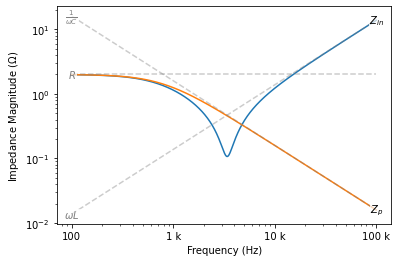

In [1]:
from fastz import R, L, C
from fastz.plotting import bodez
import numpy as np

Zin = ( L(v=22e-6) + ( C(v=100e-6) // R(v=2.0) )['p'] )['in']
fig, ax = bodez(Zin, ff=np.logspace(2, 5, 1000), zlines='Zin Zp', refzlines='R L C')

In [2]:
Zin(3_000.0)

(0.1314731604517404-0.0809519077494511j)

In [3]:
Zin(np.array([100, 1_000, 10_000]))

array([1.96890825-0.2335973j , 0.77545327-0.83623325j,
       0.01258545+1.22414734j])

In [4]:
Zin.breakfreq('R C')

795.7747154594767

## Installation

Install the fastZ package with `pip`:

    pip install fastz
    
Dependencies: numpy and matplotlib

## Usage

### Constructing Impedance Models

Many impedance networks can be represented by series and parallel combinations of RLC elements. The fastZ package provides the classes `R`, `L`, and `C` along with the series and parallel operators `+` and `//` for this purpose. For example, a resistor R1 with a value of 50Ω is constructed as:

In [5]:
R1 = R('1', 50)
str(R1)

'R1[50Ω]'

The first argument to the constructor is the resistor's _subscript_. It gets appended to the the resistor's _prefix_ 'R' to form the _label_ 'R1'. The second argument is the resistor's value in Ohms. Both the subscript and value are optional, but keep the following rules in mind:

- If you omit the subscript, you must pass the value using the keyword argument `v`.
- If you omit the value, you must later provide it when evaulating or plotting the impedance (more about this below).

The LC constructors are similar, except that `L` accepts a value in Henreies (H) and `C` in Farads (F).

The addition operator `+` constructs series impedance networks. For example, we can build a series RC network using:

In [6]:
Zs = R(v=10.0) + C(v=1e-6)
str(Zs)

'(R[10.0Ω] + C[1e-06F])'

Similarly, the floor division operator `//` constructs parallel impedance networks. For example, a parallel RL network is constructed as:

In [7]:
Zp = R(v=100) // L(v=22e-6)
str(Zp)

'(R[100Ω] || L[2.2e-05H])'

Create more complex impedance networks by combining the series and parallel operators in hierarchy:

In [8]:
Zc = (R('1') + C('1')) // (R('2') + L('2') + C('2')) + L('3') // C('3')
str(Zc)

'(((R1 + C1) || (R2 + L2 + C2)) + (L3 || C3))'

### Evalulating Impedance Models

Call an impedance with a single frequency or numpy array of frequencies using the call operator `()` to evalulate the impedance at those frequencies. For example, suppose we have the impedance:

In [9]:
Z = L(v=22e-6) + C(v=100e-6) // R(v=2.0)

You can evalulate its value at a frequency of 4kHz using:

In [10]:
Z(3e3)

(0.1314731604517404-0.0809519077494511j)

Or evalulate the impedance over multiple frequencies using:

In [11]:
Z(np.array([1, 1e3, 100e3]))

array([1.99999684e+00-2.37504008e-03j, 7.75453273e-01-8.36233246e-01j,
       1.26643460e-04+1.38070932e+01j])

If you omitted element values when constructing an impedance network, or want to temporarily overwrite the values of some elements, you'll need to pass the element values as keyword arguments to the call operator:

In [12]:
Z(3e3, L=100e-6, R=100.0)

(0.0028143981128015963+1.3544540460266075j)

### Plotting Impedance Models

The `bodez` function provided within the `plotting` module draws the Bode magnitude plot of an impedance given a numpy array of the frequencies at which to evaulate the impedance. Use the optional string argument `zlines` to specify the whitespace-separated labels of additional sub-impedances to draw on the plot. The optional string argument `refzlines` specifies the labels of sub-impedances to plot in the reference-line style (dashed gray by default.) To change the horizontal postion of an impedances curve's annotation, append a colon followed by the horizontal location in frequency units. For example:

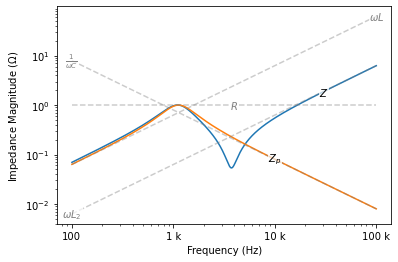

In [13]:
Z = (R(v=1) // L(v=100e-6) // C(v=200e-6))['p'] + L('2', 10e-6)
fig, ax = bodez(Z, ff=np.logspace(2, 5, 1000), zlines='Z:30000 Zp:10000', refzlines='R:4000 L:100e3 C L2')

If you omitted element values when constructing an impedance network, or want to temporarily overwrite the values of some elements, you'll need to pass the element values as keyword arguments as well:

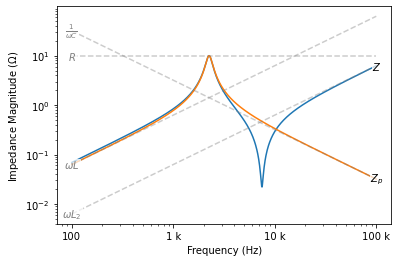

In [14]:
fig, ax = bodez(Z, ff=np.logspace(2, 5, 1000), zlines='Zp', refzlines='R L C L2', R=10, C=50e-6)

### Using Subscripts

Subscripts are string or integer suffix values that help identify resistors, inductors, capacitors, and composite impedances. To assign a subscript to an RLC element, pass it to the constructor:

In [15]:
La = L('a', 1e-6)
str(La)

'La[1e-06H]'

You can assign a subscript to a composite impedance using the subscript operator `[]`:

In [16]:
Zin = (R(v=1.0) + La)['in']
str(Zin)

'Zin:(R[1.0Ω] + La[1e-06H])'

Bode plot annotations reflect the appropriate subscripts:

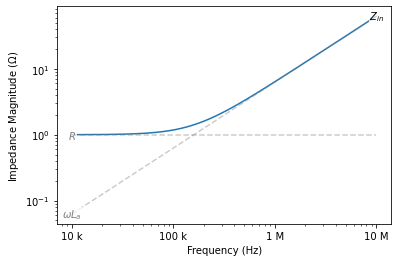

In [17]:
fig, ax = bodez(Zin, ff=np.logspace(4, 7, 1000), refzlines='R La')

### Accessing Sub-Impedances

We might build an impedance network consisting of multiple labeled subportions. For example:

In [18]:
Z1 = (C('1') + L('1'))['a'] // (R('2') + L('2'))['b'] // C('3')
str(Z1)

'(Za:(C1 + L1) || Zb:(R2 + L2) || C3)'

Sometimes it may be useful to access the sub-impedances Za and Zb, or the individual RLC elements. Use the `subz` method to do so:

In [19]:
Za = Z1.subz('Za')
str(Za)

'Za:(C1 + L1)'

In [20]:
C1 = Z1.subz('C1')
str(C1)

'C1'

Internally, the `bodez` plotting function relies on the `subz` method to plot additional impedances specified in the `zlines` and `refzlines` arguments

### Computing Break Frequencies

The `breakfreq` method computes RC, RL, and LC break frequencies. A break frequency is the frequency at which one element's impedance magnitude equals the other element's impedance magnitude. Suppose we have the following parallel RLC network:

In [21]:
Z1 = R(v=1) // L(v=100e-6) // C(v=22e-6)
str(Z1)

'(R[1Ω] || L[0.0001H] || C[2.2e-05F])'

The following draws vertical lines at the RC, RL, and LC break frequencies:

(0.1, 3)

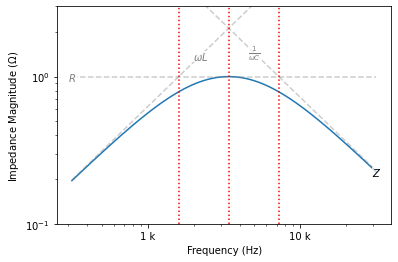

In [22]:
fig, ax = bodez(Z1, ff=np.logspace(2.5, 4.5, 1000), refzlines='R L:2200 C:5000')
for fb in [Z1.breakfreq('R L'), Z1.breakfreq('L C'), Z1.breakfreq('R C')]:
    ax.axvline(x=fb, ls=':', color='red')

ax.set_ylim((0.1, 3))

<a name="examples"/>

## Examples

### SMPS Output Impedance

Here's a model of the small-signal output impedance of a Buck, Boost, or Buck-Boost converter (switching-mode power supplies):

<img src="fastZ_smps_zout.svg" alt="SMPS output impedance" width="500" />

Le is the effective output inductance of the converter, C is the output capacitor, and Rload represents the load. To make things a bit more interesting, we've included the inductor's ohmic loss as RL and the capacitor's equivalent series inductance and resistance as Lesl and Resr, respectively. We construct and evaluate a fastZ model with some sample component values below:

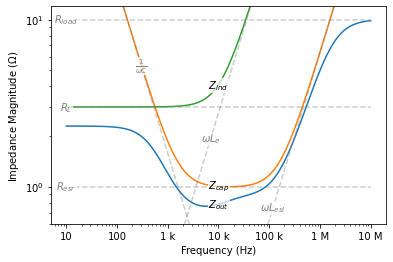

In [23]:
from fastz import R, L, C
from fastz.plotting import bodez
import numpy as np
import matplotlib.pyplot as plt

Zout = ( R('load', 10) // (L('esl', 1e-6) + C(v=100e-6) + R('esr', 1))['cap'] // (L('e', 44e-6) + R('L', 3.0))['ind'] )['out']
bodez(Zout, ff=np.logspace(1, 7, 1000), 
      zlines='Zout:10e3 Zcap:10e3 Zind:10e3', 
      refzlines='Rload C:300 Lesl:120e3 Resr Le:7e3 RL')
plt.ylim((0.6, 12))
plt.show()

### PID Compensator

This op amp circuit could appear in a feedback control loop as a PID (lead-lag) compensator:

<img src="fastZ_pid_comp.svg" alt="PID compensator" width=500 />

VREF represents the setpoint of the feedback system (assumed constant in this case), vfb is the feedback voltage signal, and vc is the compensated output voltage signal. The transfer relationship is

    Vc(s) = Gc(s)·Ve(s)

where ve = VREF - vfb is the error signal and Gc(s) = Z1(s)/Z2(s) is the compensator's transfer function. We can use fastZ to compute Gc since it is the ratio of two lumped-element impedance networks.

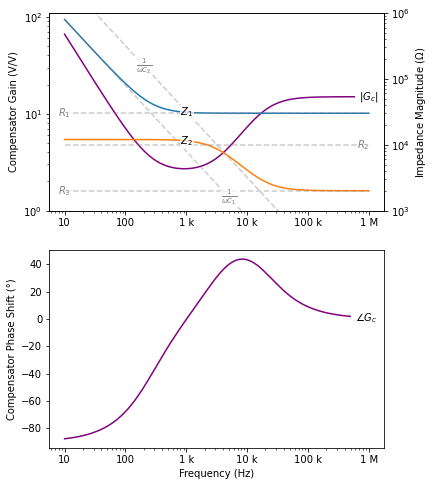

In [24]:
from fastz import R, L, C
from fastz.plotting import bodez
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# construct models of Z1 and Z2
Z1 = ( R('1', 30e3) + C('1', 20e-9) )['1']
Z2 = ( R('2', 10e3) // C('2', 5e-9) + R('3', 2e3) )['2']

# evalulate frequency response of Gc
ff = np.logspace(1, 6, 1000)
GGc = Z1(ff) / Z2(ff)

# plot the results
fig, (axm, axp) = plt.subplots(2, 1, figsize=(6, 8))
axz = axm.twinx()

bodez(Z1, ff, ax=axz, zlines='Z1:1e3', refzlines='R1 C1:5e3')
bodez(Z2, ff, ax=axz, zlines='Z2:1e3', refzlines='R2:800e3 R3 C2:200')
axm.loglog(ff, np.abs(GGc), color='purple')
axp.semilogx(ff, np.angle(GGc)*180/np.pi, color='purple')
axm.annotate('$|G_c|$', (ff[-1], abs(GGc[-1])), 
             ha='center', va='center', backgroundcolor='w')
axp.annotate('$\\angle G_c$', (ff[-10], np.angle(GGc[-10])*180/np.pi), 
             ha='center', va='center', backgroundcolor='w')

axm.xaxis.set_major_formatter(EngFormatter())
axp.xaxis.set_major_formatter(EngFormatter())
axm.set_ylabel('Compensator Gain (V/V)')
axp.set_ylabel('Compensator Phase Shift (°)')
axp.set_xlabel('Frequency (Hz)')
axm.set_ylim((1, 110))
axz.set_ylim((1e3, 1e6))
plt.show()

You can see that there's a phase boost of about 40° at 10kHz. An inverted zero appears at about 300Hz to boost the low-frequency gain.